In [31]:
from pathlib import Path

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from plot_functions import bar_plot, distribution_plot, line_plot_variables, violin_plot

## SETUP

In [32]:
# prompt version (currently only working with 2.0, but nice to be able to easily change)
version = 3.0

In [33]:
metrics_dir = Path.cwd().parents[0] / "metrics"

plots_dir = Path.cwd().parents[0] / "plots" / f"v{version}"

curves_dir = plots_dir / "curves"
barplots_dir = plots_dir / "barplots"
postags_dir = plots_dir / "postags"

for dir in [curves_dir, barplots_dir, postags_dir]:
    dir.mkdir(parents=True, exist_ok=True)

In [34]:
# for giving shorter names in df 
model_dict = {
    "mlx-community--Qwen2.5-7B-Instruct-1M-4bit": "Qwen 2.5 7B Instruct 1M (4bit)",
    "mlx-community--meta-Llama-3.1-8B-Instruct-4bit": "Llama 3.1 8B Instruct (4bit)",
    "meta-llama--Llama-3.1-8B-Instruct": "Llama 3.1 8B Instruct",
    "Qwen--Qwen2.5-7B-Instruct": "Qwen 2.5 7B Instruct",
    "mistralai--Mistral-7B-Instruct-v0.3": "Mistral 7B Instruct v0.3",
}

## Text Stats

### Load and Process

In [35]:
group_levels = pl.Enum(["A1", "B1", "C1"])
text_stats_df = pl.read_csv(metrics_dir / f"v{version}_text_stats.csv", schema_overrides={"group": group_levels}) 

In [36]:
text_stats_df = text_stats_df.with_columns(pl.col("model").replace_strict(model_dict))

### Plot

In [37]:
role = "assistant"
filtered_text_stats_df = text_stats_df.filter(pl.col("role") == role)

# assign message numbers
filtered_text_stats_df = filtered_text_stats_df.with_columns(total_message_number=pl.int_range(1, pl.len() + 1).over("id"))


cols = ["fernandez_huerta", "szigriszt_pazos", "gutierrez_polini", "flesch_kincaid_grade", "crawford"]
# compute average scores
agg_df = (
    filtered_text_stats_df.group_by(["model", "group", "total_message_number"], maintain_order=True)
    .agg([
        *[pl.col(col).mean().alias(f"{col}_mean") for col in cols],
        *[pl.col(col).std().alias(f"{col}_std") for col in cols],
        *[pl.col(col).count().alias(f"{col}_count") for col in cols],
    ])
)


In [38]:
def add_ci_to_col(df, col):
    """
    Add ci, ci_low, ci_high columns to Polars DataFrame
    """
    # First calculate the CI column
    df = df.with_columns(
        (1.96 * pl.col(f"{col}_std") / (pl.col(f"{col}_count").sqrt())).alias(f"{col}_ci")
    )
    
    # Now calculate the low and high CI bounds using the already computed CI
    df = df.with_columns(
        (pl.col(f"{col}_mean") - pl.col(f"{col}_ci")).alias(f"{col}_ci_lower"),
        (pl.col(f"{col}_mean") + pl.col(f"{col}_ci")).alias(f"{col}_ci_high"),
    )
    
    return df

In [39]:
for col in cols:
    agg_df = add_ci_to_col(agg_df, col)

In [40]:
agg_df

model,group,total_message_number,fernandez_huerta_mean,szigriszt_pazos_mean,gutierrez_polini_mean,flesch_kincaid_grade_mean,crawford_mean,fernandez_huerta_std,szigriszt_pazos_std,gutierrez_polini_std,flesch_kincaid_grade_std,crawford_std,fernandez_huerta_count,szigriszt_pazos_count,gutierrez_polini_count,flesch_kincaid_grade_count,crawford_count,fernandez_huerta_ci,fernandez_huerta_ci_lower,fernandez_huerta_ci_high,szigriszt_pazos_ci,szigriszt_pazos_ci_lower,szigriszt_pazos_ci_high,gutierrez_polini_ci,gutierrez_polini_ci_lower,gutierrez_polini_ci_high,flesch_kincaid_grade_ci,flesch_kincaid_grade_ci_lower,flesch_kincaid_grade_ci_high,crawford_ci,crawford_ci_lower,crawford_ci_high
str,enum,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,u32,u32,u32,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Llama 3.1 8B Instruct""","""C1""",1,92.454,88.872,46.905,8.66,2.65,9.603435,11.054692,4.31302,1.656771,0.673713,10,10,10,10,10,5.952271,86.501729,98.406271,6.851769,82.020231,95.723769,2.673237,44.231763,49.578237,1.026877,7.633123,9.686877,0.417571,2.232429,3.067571
"""Llama 3.1 8B Instruct""","""C1""",2,87.389,84.329,42.918,10.47,3.63,5.975224,5.302042,3.055941,1.289315,0.434741,10,10,10,10,10,3.703482,83.685518,91.092482,3.28624,81.04276,87.61524,1.894092,41.023908,44.812092,0.799126,9.670874,11.269126,0.269455,3.360545,3.899455
"""Llama 3.1 8B Instruct""","""C1""",3,85.983,82.565,42.029,11.46,3.76,6.212276,7.397787,3.401586,1.795798,0.566078,10,10,10,10,10,3.850409,82.132591,89.833409,4.585196,77.979804,87.150196,2.108325,39.920675,44.137325,1.113047,10.346953,12.573047,0.350859,3.409141,4.110859
"""Llama 3.1 8B Instruct""","""C1""",4,82.359,79.342,40.564,12.39,4.04,8.17609,8.689578,4.561594,2.035491,0.667,10,10,10,10,10,5.067593,77.291407,87.426593,5.385857,73.956143,84.727857,2.827305,37.736695,43.391305,1.26161,11.12839,13.65161,0.413411,3.626589,4.453411
"""Llama 3.1 8B Instruct""","""C1""",5,83.216,78.315,40.057,12.72,4.02,10.580002,10.71518,6.062178,2.9154,0.723878,10,10,10,10,10,6.557553,76.658447,89.773553,6.641337,71.673663,84.956337,3.757377,36.299623,43.814377,1.806983,10.913017,14.526983,0.448665,3.571335,4.468665
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Mistral 7B Instruct v0.3""","""A1""",5,92.093,89.876,43.427,9.14,3.01,4.666874,4.389789,2.313992,1.233063,0.521643,10,10,10,10,10,2.892558,89.200442,94.985558,2.72082,87.15518,92.59682,1.434227,41.992773,44.861227,0.76426,8.37574,9.90426,0.323317,2.686683,3.333317
"""Mistral 7B Instruct v0.3""","""A1""",6,93.242,89.775,44.094,9.02,3.05,5.006538,5.413293,2.275547,1.472564,0.56421,10,10,10,10,10,3.103084,90.138916,96.345084,3.355194,86.419806,93.130194,1.410399,42.683601,45.504399,0.912705,8.107295,9.932705,0.349701,2.700299,3.399701
"""Mistral 7B Instruct v0.3""","""A1""",7,93.364,89.793,43.615,8.97,3.04,5.126409,5.264023,2.173534,1.371982,0.589161,10,10,10,10,10,3.177381,90.186619,96.541381,3.262675,86.530325,93.055675,1.34717,42.26783,44.96217,0.850363,8.119637,9.820363,0.365166,2.674834,3.405166


ColumnNotFoundError: "fernandez_huerta_ci_ci_lower" not found

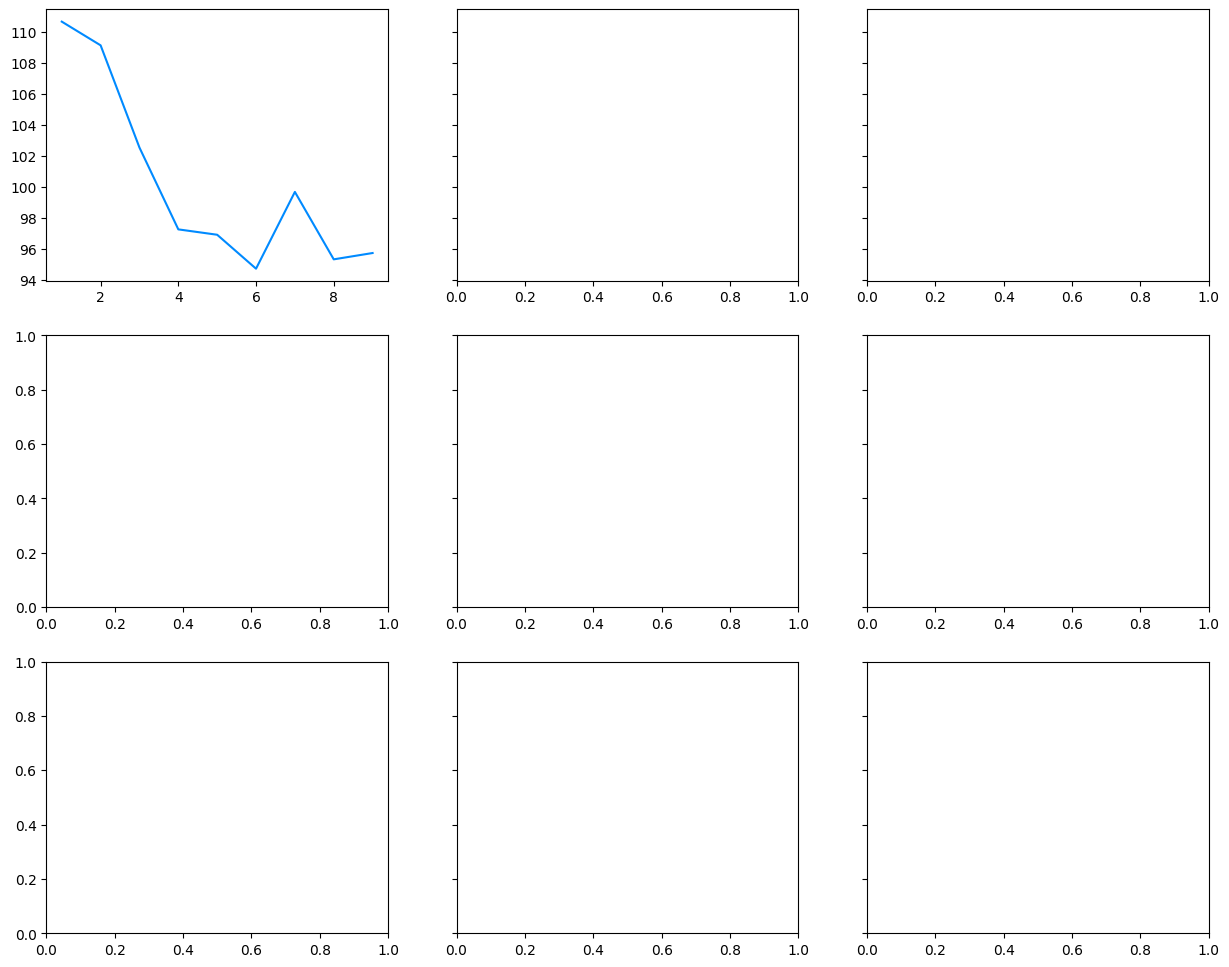

In [56]:
colors = ["#008aff", "#ff471a", "#00a661"]

cols = ["fernandez_huerta", "szigriszt_pazos", "gutierrez_polini"]
vars = [f"{col}_mean" for col in cols]
ci_vars = [f"{col}_ci" for col in cols]

fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=vars, 
                    ci_vars=ci_vars,
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

fig.savefig(plots_dir / "curves" / "spanish_readability_high_easy.png", dpi=300)

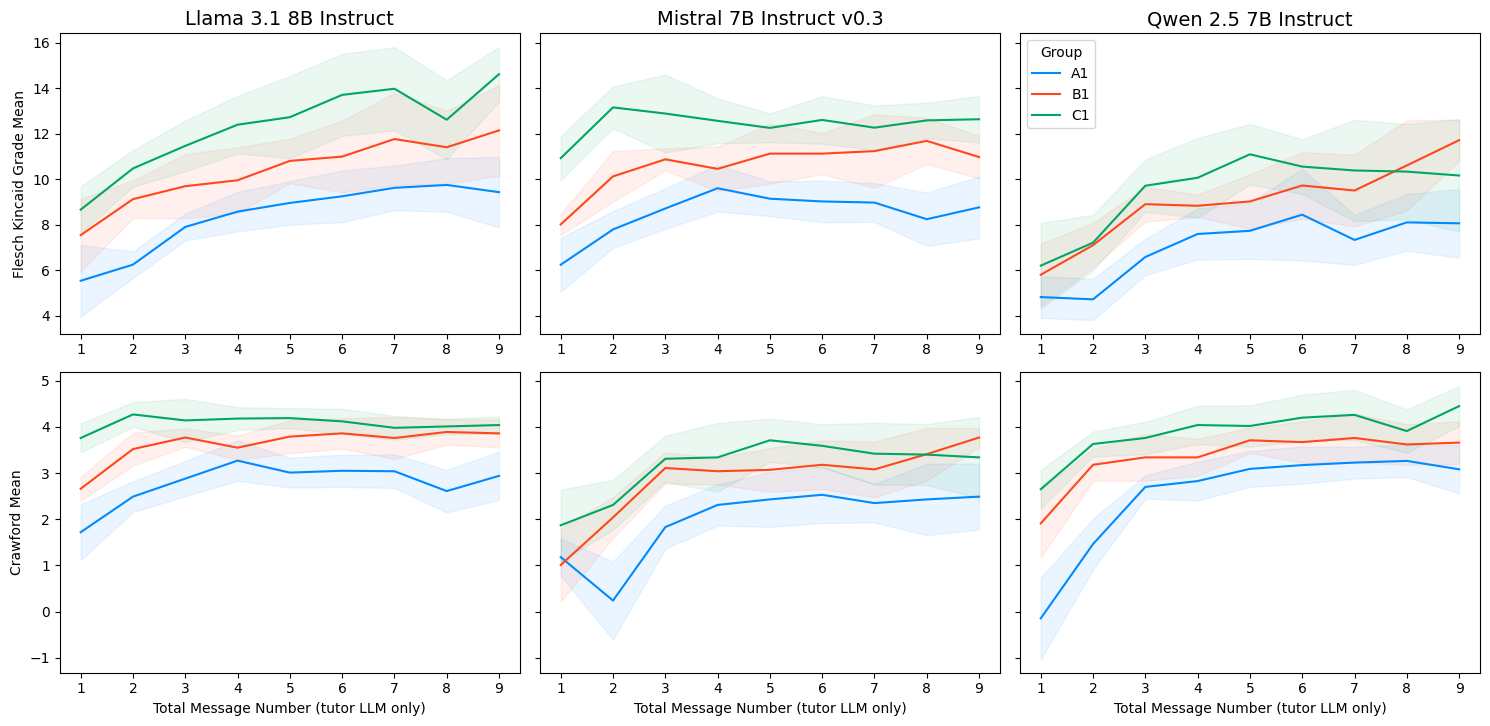

In [42]:
colors = ["#008aff", "#ff471a", "#00a661"]

cols = ["flesch_kincaid_grade", "crawford"]
vars = [f"{col}_mean" for col in cols]

fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=vars,
                    ci_vars=cols,
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

fig.savefig(plots_dir / "curves" / "spanish_readability_high_difficult.png", dpi=300)

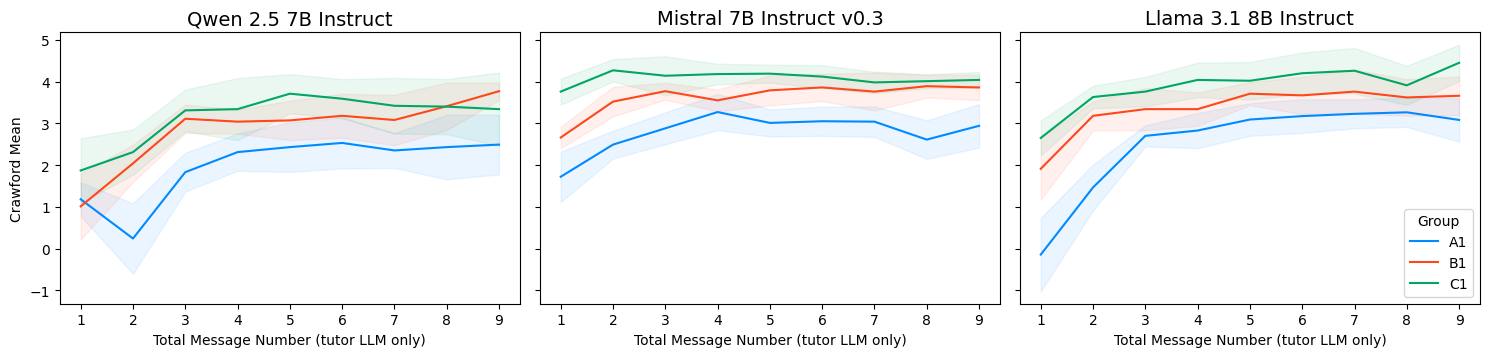

In [57]:
colors = ["#008aff", "#ff471a", "#00a661"]

fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=["crawford_mean"], 
                    ci_vars=["crawford"],
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

fig.savefig(plots_dir / "curves" / "crawford.png", dpi=300)

## Text Descriptives

In [44]:
group_levels = pl.Enum(["A1", "B1", "C1"])

td_df = pl.read_csv(metrics_dir / f"v{version}_textdescriptives.csv", schema_overrides={"group": group_levels}) 

td_df = td_df.with_columns(pl.col("model").replace_strict(model_dict))

In [45]:
role = "assistant"
filtered_td_df = td_df.filter(pl.col("role") == role)
# assign message numbers
filtered_td_df = filtered_td_df.with_columns(total_message_number=pl.int_range(1, pl.len() + 1).over("id"))

## Doc Length

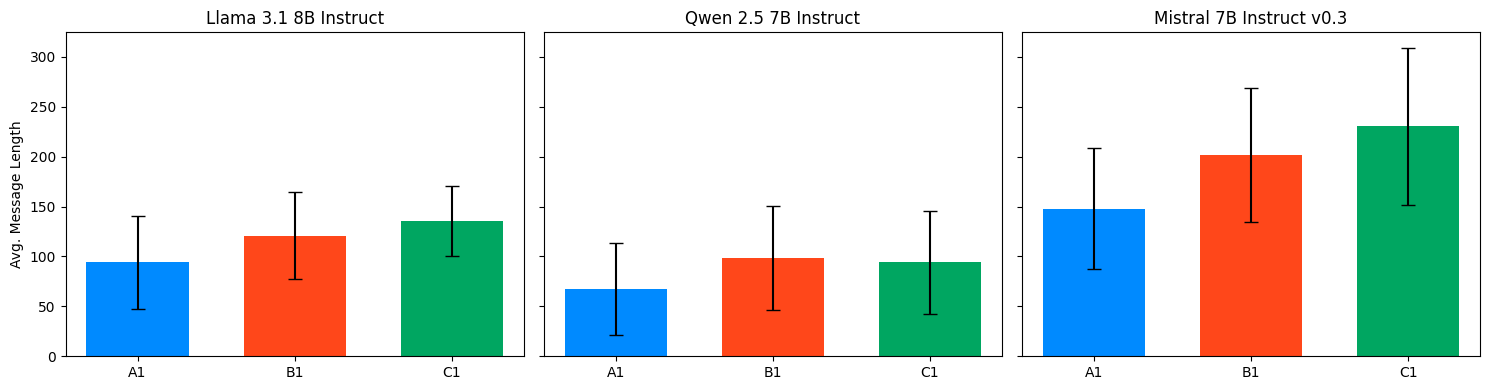

In [46]:
avg_df = (
    filtered_td_df
    .group_by(["model", "group"], maintain_order=True)
    .agg([
        pl.col("doc_length").mean().alias("mean_doc_length"),
        pl.col("doc_length").std().alias("std_doc_length"),
    ])
)

fig = bar_plot(avg_df, 
                x_vars=["mean_doc_length"],
                std_vars = ["std_doc_length"], 
                y_label_texts=["Avg. Message Length"])

fig.savefig(plots_dir / "barplots" /  "avg_message_length.png", dpi=300)

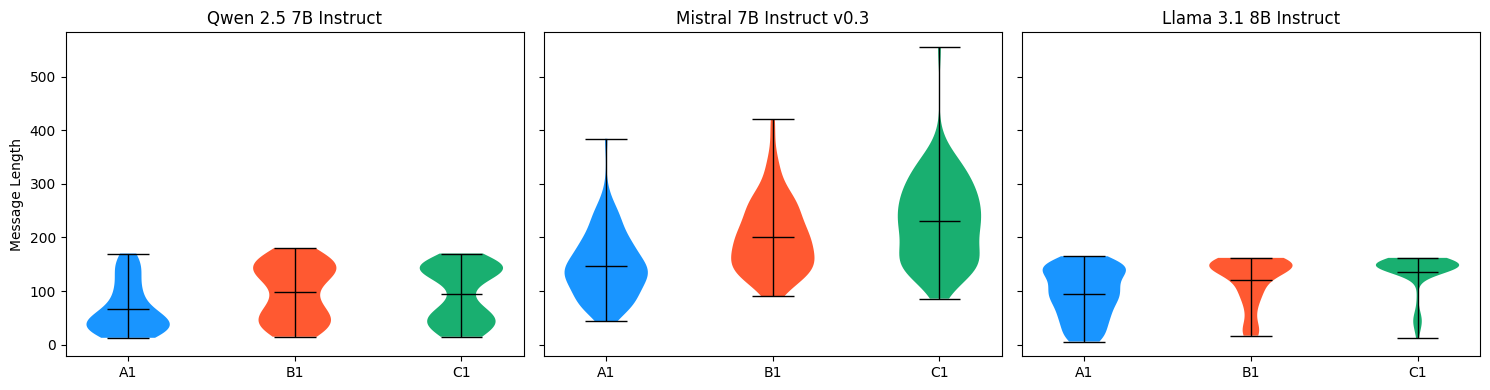

In [47]:
fig = violin_plot(
    filtered_td_df,  # Use the full dataset
    x_vars=["doc_length"],  # Pass raw values instead of mean
    group_var="group",
    model_var="model",
    y_label_texts=["Message Length"]
)

fig.savefig(plots_dir / "message_length_violin.png", dpi=300)

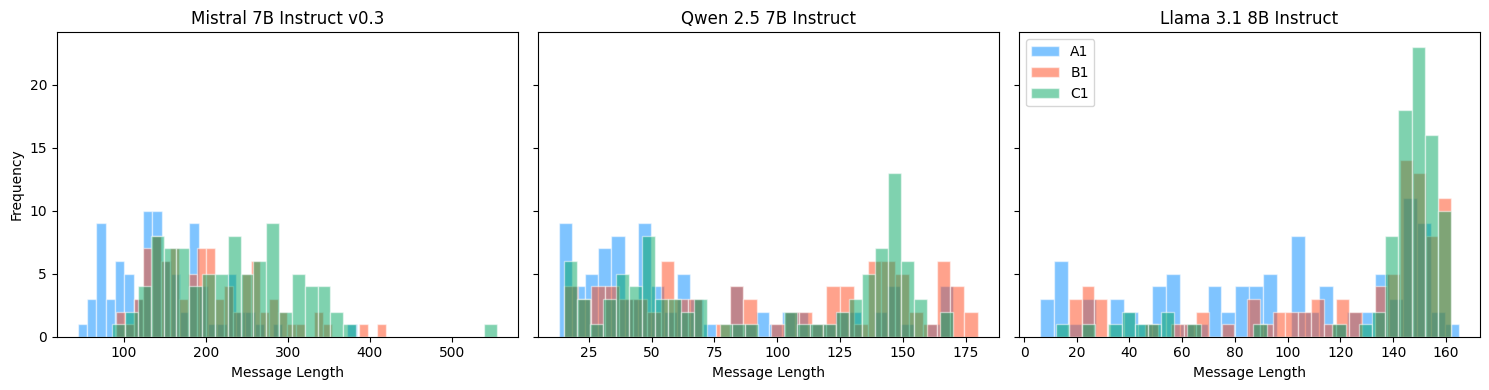

In [48]:
fig = distribution_plot(filtered_td_df, x_vars=["doc_length"], normalize=False, alpha=0.5, x_label_texts=["Message Length"])

fig.savefig(plots_dir / "message_length_dist.png", dpi=300)

### Unique Tokens

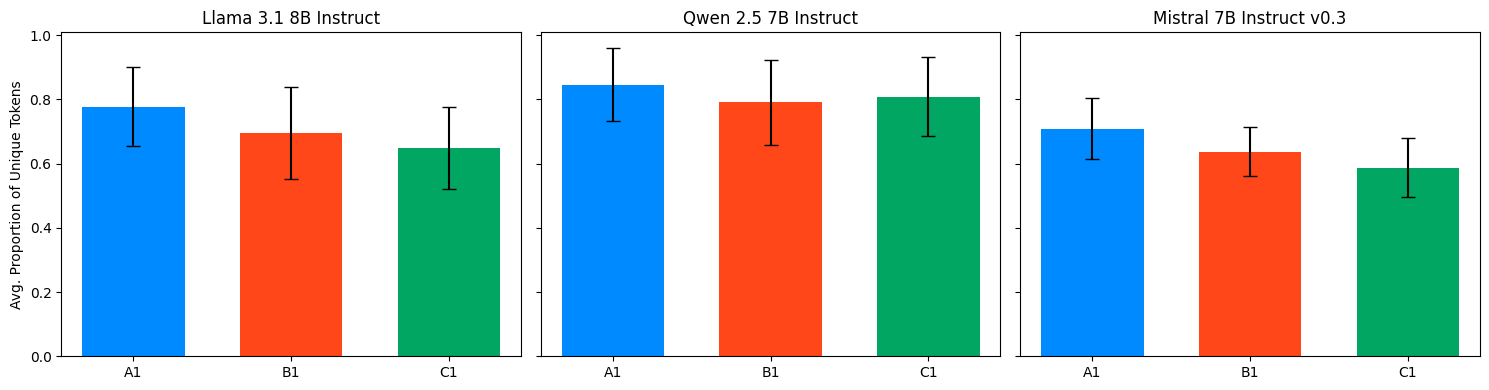

In [49]:
avg_df = (
    filtered_td_df
    .group_by(["model", "group"], maintain_order=True)
    .agg([
        pl.col("proportion_unique_tokens").mean().alias("mean_proportion_unique_tokens"),
        pl.col("proportion_unique_tokens").std().alias("std_proportion_unique_tokens")
    ])
)

fig = bar_plot(avg_df, 
                x_vars=["mean_proportion_unique_tokens"],
                std_vars = ["std_proportion_unique_tokens"], 
                y_label_texts=["Avg. Proportion of Unique Tokens"])

fig.savefig(plots_dir / "barplots" / "avg_proportion_of_unique_tokens.png", dpi=300)

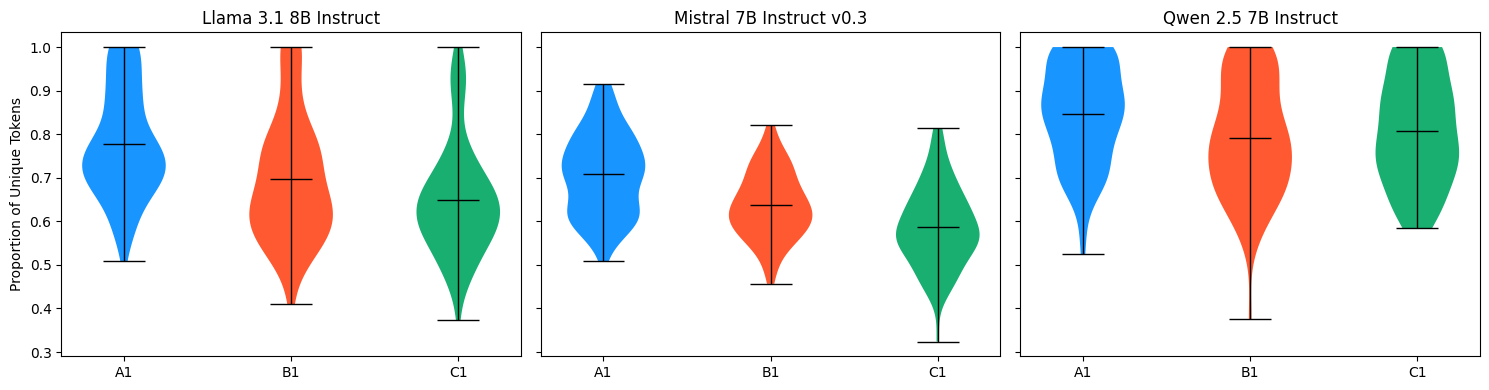

In [50]:
fig = violin_plot(
    filtered_td_df,  # Use the full dataset
    x_vars=["proportion_unique_tokens"], 
    group_var="group",
    model_var="model",
    y_label_texts=["Proportion of Unique Tokens"]
)

fig.savefig(plots_dir / "unique_tokens_violin.png", dpi=300)

## Length and Unique Tokens over conversation length

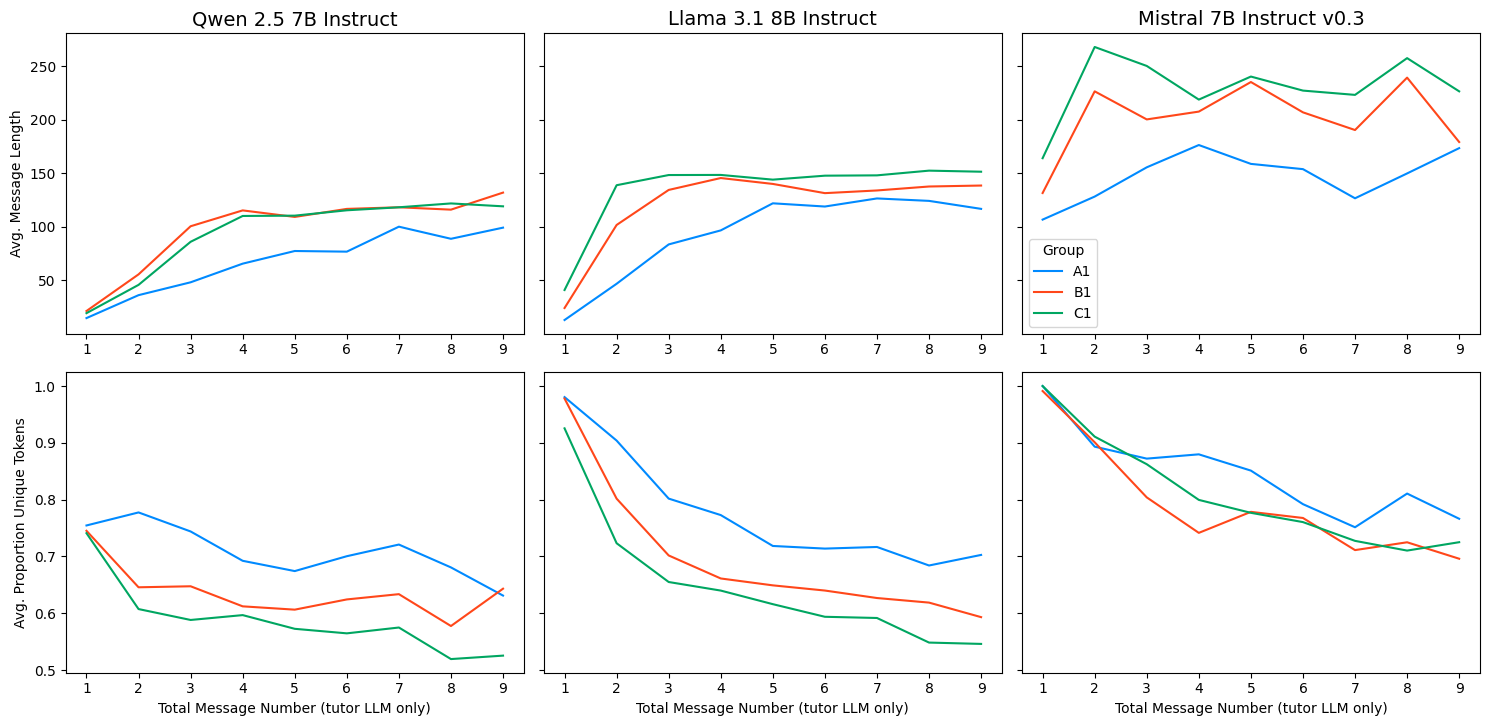

In [51]:
avg_df = (
    filtered_td_df
    .group_by(["model", "group", "total_message_number"], maintain_order=True)
    .agg([
        pl.col("doc_length").mean().alias("avg._message_length"),
        pl.col("proportion_unique_tokens").mean().alias("avg._proportion_unique_tokens"),
    ])
)

fig = line_plot_variables(df=avg_df, 
                    x_var="total_message_number", 
                    y_vars=["avg._message_length", "avg._proportion_unique_tokens"], 
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

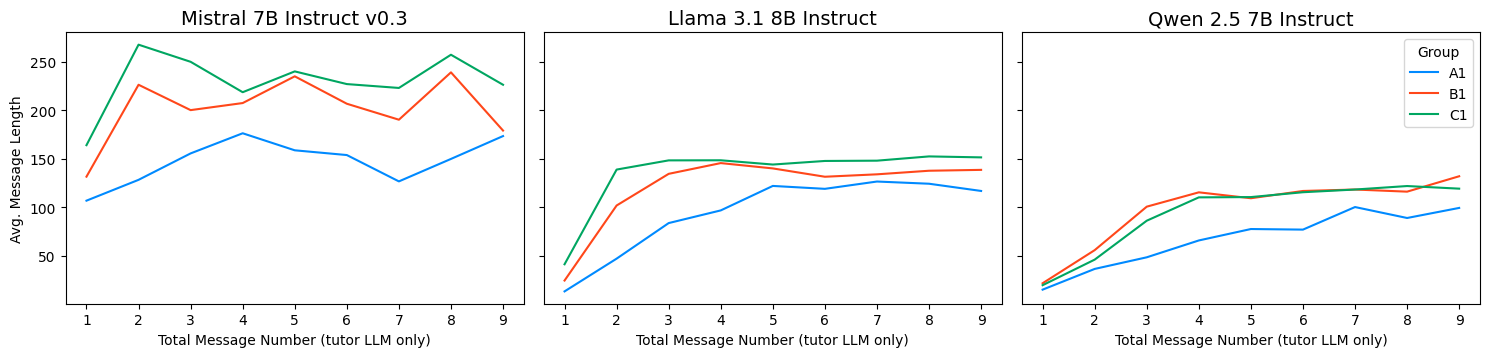

In [52]:
fig = line_plot_variables(df=avg_df, 
                    x_var="total_message_number", 
                    y_vars=["avg._message_length"],
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

fig.savefig(plots_dir / "curves" / "avg_message_length.png", dpi=300)

### Parts of Speech Tagging

In [53]:
def generate_custom_colors(n_colors):
    base_colors = ["#008aff", "#ff471a", "#00a661"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", base_colors)
    return [cmap(i / (n_colors - 1)) for i in range(n_colors)]

def plot_group_overview(df, group_col, model_col, model_name, variables, 
                        y_label_text=None, main_title=None):
    df_model = df.filter(pl.col(model_col) == model_name)
    avg_df = df_model.group_by(group_col, maintain_order=True).mean()
    groups = avg_df[group_col].unique().to_list()

    num_vars = len(variables)
    fig, axes = plt.subplots(1, len(groups), figsize=(5 * len(groups), 4), sharey=True)

    if len(groups) == 1:
        axes = [axes]

    # Generate custom colors
    colors = generate_custom_colors(num_vars)

    for ax, group in zip(axes, groups):
        group_data = avg_df.filter(pl.col(group_col) == group)
        proportions = [group_data[var][0] for var in variables]

        x = np.arange(len(variables))
        ax.bar(x, proportions, color=colors)

        ax.set_xticks(x)
        ax.set_xticklabels(variables, rotation=45, ha="right")
        ax.set_title(f"{group}")
        
        if y_label_text: 
            ax.set_ylabel(y_label_text)
    
    if main_title: 
        fig.suptitle(main_title)

    plt.tight_layout()

    return fig

In [54]:
pos_props = [
    "pos_prop_ADJ", "pos_prop_ADP", "pos_prop_ADV", "pos_prop_AUX",
    "pos_prop_CCONJ", "pos_prop_DET", "pos_prop_INTJ", "pos_prop_NOUN",
    "pos_prop_NUM", "pos_prop_PART", "pos_prop_PRON", "pos_prop_PROPN",
    "pos_prop_PUNCT", "pos_prop_SCONJ", "pos_prop_SYM", "pos_prop_VERB",
] # https://universaldependencies.org/u/pos/

rename_mapping = {col: col.replace("pos_prop_", "") for col in pos_props}
new_pos_props_names = list(rename_mapping.values())
filtered_td_df = filtered_td_df.rename(rename_mapping)

In [55]:
model_1 = list(model_dict.values())[0]
plot = plot_group_overview(filtered_td_df, group_col="group", model_col = "model", model_name=model_1, variables=new_pos_props_names, y_label_text = "Proportion", main_title=model_1)

plot.savefig(plots_dir / "postags" / "qwen_pos.png", dpi=300)

ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x400 with 0 Axes>

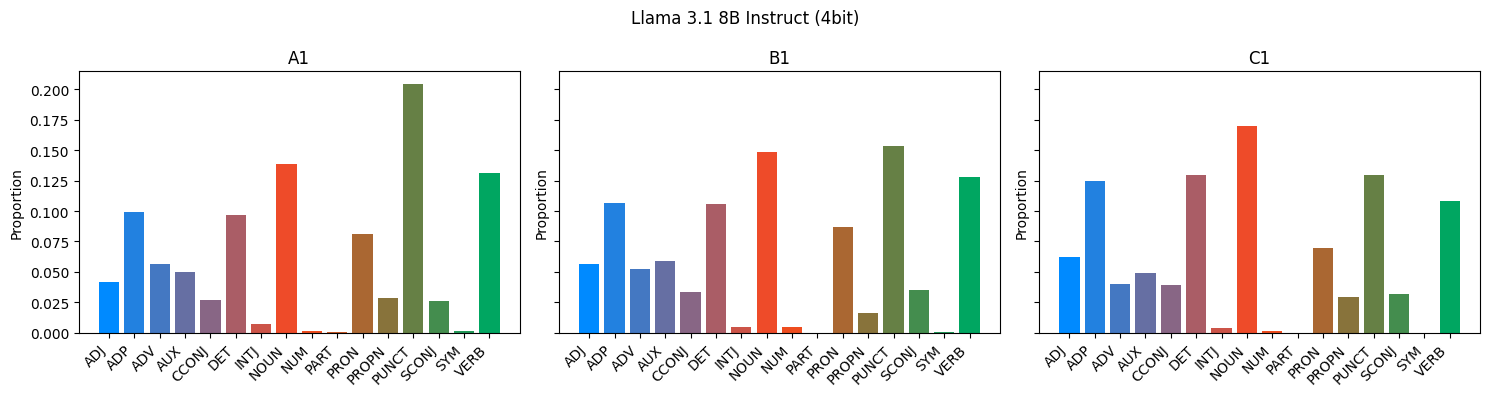

In [ ]:
model_1 = list(model_dict.values())[1]
plot = plot_group_overview(filtered_td_df, group_col="group", model_col = "model", model_name=model_1, variables=new_pos_props_names, y_label_text = "Proportion", main_title=model_1)

plot.savefig(plots_dir / "postags" / "llama_pos.png", dpi=300)